# Neural Networks for Homomorphic Encryption

In this notebook, we explore neural network architectures that are compatible with the CKKS encryption scheme, and evaluate their performance. The dataset (which I'm not permitted to upload) consists of ICU patients' EHR data.

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
from typing import List

In [2]:
df = pd.read_csv('../training_v2.csv')

## Data preprocessing

One-hot encoding:

In [7]:
def one_hot(df: pd.DataFrame, colname: str) -> pd.DataFrame:
    """
    Converts column colname of df to one-hot encoding.
    """
    return pd.concat([df,pd.get_dummies(df[colname], prefix=colname,dummy_na=True)],axis=1).drop([colname],axis=1)
def one_hot_list(df: pd.DataFrame, colnames: List[str]) -> pd.DataFrame:
    """
    Converts column in colnames of df to one-hot encoding.
    """
    for colname in colnames:
        df = one_hot(df, colname)
    return df

In [8]:
df = one_hot_list(df, ['ethnicity', 'gender', 'hospital_admit_source',
                  'icu_admit_source', 'icu_stay_type',
                 'icu_type', 'apache_2_diagnosis', 'apache_3j_diagnosis',
                 'apache_3j_bodysystem', 'apache_2_bodysystem'])


Replace nan values by their mode

In [9]:
for column in df.columns:
    df[column] = df[column].fillna(df[column].mode()[0])

In [17]:
df.weight

0         98.60
1        103.42
2         77.50
3         79.00
4         60.70
          ...  
91208     90.90
91209     59.00
91210     89.00
91211     61.20
91212     77.10
Name: weight, Length: 99100, dtype: float64

Over-sample (unbalanced dataset):

In [7]:
df_test = df[-500:]
df = df[:-500]
df = df.append(df[df['hospital_death']==1])

Shuffle:

In [8]:
df=df.set_index(np.random.permutation(df.index))
df.sort_index(inplace=True)

In [9]:
X_data = df.drop(columns=['hospital_death'])
y_data = df['hospital_death']
X_test = df_test.drop(columns=['hospital_death'])
y_test = df_test['hospital_death']

In [10]:
X_train = X_data[:-500]
y_train = y_data[:-500]

X_val = X_data[-500:]
y_val = y_data[-500:]

In [11]:
y_train

0        0
1        0
2        1
3        0
4        0
        ..
90731    0
90732    0
90733    0
90734    0
90735    0
Name: hospital_death, Length: 98600, dtype: int64

In [18]:
X_train.shape[1]

688

## Modelling experiments

In [12]:

import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Activation,
    AveragePooling2D,
    Flatten,
    Convolution2D,
    MaxPooling2D,
    Reshape,
    Input,
    Dropout
)

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import (SGD, RMSprop, Adam, Nadam)

feature_dim = X_train.shape[1]
batch_size = 100

def sq_model(input):

    def square_activation(x):
        return 1/batch_size * x * x

    y = Dense(
        200 ,
        use_bias = True,
        input_shape=(feature_dim,),kernel_regularizer='l2',
        name="fc1"
    )(input)
    y = Activation(square_activation)(y)
    y = Dropout(rate=0.3)(y, training=True)
    y = Dense(
        50 ,
        use_bias = True,
        kernel_regularizer='l2',name="fc13"
    )(y)
    y = Activation(square_activation)(y)
    y = Dropout(rate=0.3)(y, training=True)
    y = Dense(2, use_bias=True, name="fc_2", kernel_regularizer='l2')(y)

    return y


In [13]:
x_tf = Input(shape=(feature_dim,), name="input")

y_tf = sq_model(x_tf)
tf_model = Model(inputs=x_tf, outputs=y_tf)
print(tf_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 688)]             0         
_________________________________________________________________
fc1 (Dense)                  (None, 200)               137800    
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
fc13 (Dense)                 (None, 50)                10050     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
______________________________________________

In [14]:
def lossf(labels, logits):
    return tf.keras.losses.binary_crossentropy(
        labels, logits, from_logits=True)

#optimizer = SGD(learning_rate=1e-4, momentum=0.9)
optimizer = Adam(learning_rate=1e-4)

tf_model.compile(
    optimizer=optimizer, loss=lossf, metrics=["accuracy","AUC"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
hist = tf_model.fit(
X_train,
        tf.keras.utils.to_categorical(y_train),
        epochs=200,
        batch_size=100,
        validation_data=(X_val, tf.keras.utils.to_categorical(y_val)),
        verbose=1)

Train on 98600 samples, validate on 500 samples
Epoch 1/200
98600/98600 [==============================] - 11s 110us/sample - loss: 28382.4957 - acc: 0.7559 - auc: 6.5681e-05 - val_loss: 15546.8562 - val_acc: 0.7920 - val_auc: 0.0000e+00
Epoch 2/200
98600/98600 [==============================] - 12s 119us/sample - loss: 13402.7234 - acc: 0.7559 - auc: 6.5596e-05 - val_loss: 7926.6233 - val_acc: 0.7700 - val_auc: 0.0000e+00
Epoch 3/200
98600/98600 [==============================] - 10s 106us/sample - loss: 6341.1842 - acc: 0.7560 - auc: 1.3066e-04 - val_loss: 3649.0457 - val_acc: 0.7480 - val_auc: 0.0000e+00
Epoch 4/200
98600/98600 [==============================] - 13s 134us/sample - loss: 3221.7156 - acc: 0.7562 - auc: 2.2344e-04 - val_loss: 1848.0925 - val_acc: 0.7700 - val_auc: 0.0000e+00
Epoch 5/200
98600/98600 [==============================] - 10s 106us/sample - loss: 1714.2716 - acc: 0.7551 - auc: 2.5051e-04 - val_loss: 984.8945 - val_acc: 0.7980 - val_auc: 0.0015
Epoch 6/200
98

Epoch 47/200
98600/98600 [==============================] - 15s 153us/sample - loss: 0.6592 - acc: 0.8527 - auc: 0.0457 - val_loss: 0.6371 - val_acc: 0.8740 - val_auc: 0.0433
Epoch 48/200
98600/98600 [==============================] - 13s 132us/sample - loss: 0.6447 - acc: 0.8534 - auc: 0.0450 - val_loss: 0.6306 - val_acc: 0.8660 - val_auc: 0.0301
Epoch 49/200
98600/98600 [==============================] - 13s 127us/sample - loss: 0.6271 - acc: 0.8520 - auc: 0.0438 - val_loss: 0.5907 - val_acc: 0.8680 - val_auc: 0.0237
Epoch 50/200
98600/98600 [==============================] - 12s 123us/sample - loss: 0.6063 - acc: 0.8506 - auc: 0.0432 - val_loss: 0.5908 - val_acc: 0.8640 - val_auc: 0.0418
Epoch 51/200
98600/98600 [==============================] - 12s 125us/sample - loss: 0.5806 - acc: 0.8479 - auc: 0.0438 - val_loss: 0.6476 - val_acc: 0.8220 - val_auc: 0.0572
Epoch 52/200
98600/98600 [==============================] - 12s 126us/sample - loss: 2.5719 - acc: 0.8418 - auc: 0.0401 - val

Epoch 94/200
98600/98600 [==============================] - 13s 127us/sample - loss: 0.3887 - acc: 0.8504 - auc: 0.0432 - val_loss: 0.3768 - val_acc: 0.8680 - val_auc: 0.0462
Epoch 95/200
98600/98600 [==============================] - 10s 106us/sample - loss: 0.3891 - acc: 0.8501 - auc: 0.0457 - val_loss: 0.3908 - val_acc: 0.8580 - val_auc: 0.0321
Epoch 96/200
98600/98600 [==============================] - 9s 93us/sample - loss: 0.3892 - acc: 0.8501 - auc: 0.0460 - val_loss: 0.3876 - val_acc: 0.8580 - val_auc: 0.0441
Epoch 97/200
98600/98600 [==============================] - 10s 99us/sample - loss: 0.3886 - acc: 0.8503 - auc: 0.0461 - val_loss: 0.3720 - val_acc: 0.8620 - val_auc: 0.0482
Epoch 98/200
98600/98600 [==============================] - 8s 83us/sample - loss: 0.3887 - acc: 0.8503 - auc: 0.0452 - val_loss: 0.3611 - val_acc: 0.8760 - val_auc: 0.0486
Epoch 99/200
98600/98600 [==============================] - 9s 87us/sample - loss: 0.3892 - acc: 0.8497 - auc: 0.0458 - val_loss: 

Epoch 141/200
98600/98600 [==============================] - 12s 123us/sample - loss: 0.3859 - acc: 0.8517 - auc: 0.0453 - val_loss: 0.3622 - val_acc: 0.8700 - val_auc: 0.0433
Epoch 142/200
98600/98600 [==============================] - 12s 125us/sample - loss: 0.3841 - acc: 0.8525 - auc: 0.0451 - val_loss: 0.3970 - val_acc: 0.8660 - val_auc: 0.0398
Epoch 143/200
98600/98600 [==============================] - 12s 126us/sample - loss: 0.3857 - acc: 0.8525 - auc: 0.0449 - val_loss: 0.3564 - val_acc: 0.8760 - val_auc: 0.0402
Epoch 144/200
98600/98600 [==============================] - 12s 126us/sample - loss: 0.3860 - acc: 0.8518 - auc: 0.0462 - val_loss: 0.3978 - val_acc: 0.8580 - val_auc: 0.0385
Epoch 145/200
98600/98600 [==============================] - 12s 123us/sample - loss: 0.3864 - acc: 0.8520 - auc: 0.0447 - val_loss: 0.3664 - val_acc: 0.8700 - val_auc: 0.0318
Epoch 146/200
98600/98600 [==============================] - 12s 122us/sample - loss: 0.3850 - acc: 0.8530 - auc: 0.0446

Epoch 188/200
98600/98600 [==============================] - 8s 77us/sample - loss: 0.3833 - acc: 0.8546 - auc: 0.0429 - val_loss: 0.3562 - val_acc: 0.8680 - val_auc: 0.0503
Epoch 189/200
98600/98600 [==============================] - 7s 71us/sample - loss: 0.3849 - acc: 0.8535 - auc: 0.0428 - val_loss: 0.3663 - val_acc: 0.8700 - val_auc: 0.0490
Epoch 190/200
98600/98600 [==============================] - 7s 70us/sample - loss: 0.3852 - acc: 0.8533 - auc: 0.0425 - val_loss: 0.3656 - val_acc: 0.8640 - val_auc: 0.0424
Epoch 191/200
98600/98600 [==============================] - 7s 66us/sample - loss: 0.3836 - acc: 0.8530 - auc: 0.0429 - val_loss: 0.3570 - val_acc: 0.8800 - val_auc: 0.0449
Epoch 192/200
98600/98600 [==============================] - 7s 73us/sample - loss: 0.3834 - acc: 0.8532 - auc: 0.0424 - val_loss: 0.3901 - val_acc: 0.8660 - val_auc: 0.0452
Epoch 193/200
98600/98600 [==============================] - 7s 76us/sample - loss: 0.3852 - acc: 0.8530 - auc: 0.0435 - val_loss:

In [55]:
def relu_model(input):

    
    y = Dense(
        200 ,
        use_bias = True,
        input_shape=(feature_dim,),kernel_regularizer='l2',
        name="fc1"
    )(input)
    y = Activation('sigmoid')(y)
    y = Dropout(rate=0.3)(y, training=True)
    y = Dense(
        50 ,
        use_bias = True,
        kernel_regularizer='l2',name="fc13"
    )(y)
    y = Activation('sigmoid')(y)
    y = Dropout(rate=0.3)(y, training=True)
    y = Dense(2, use_bias=True, name="fc_2", kernel_regularizer='l2')(y)

    return y


In [56]:
feature_dim = X_train.shape[1]

x_n = Input(shape=(feature_dim,), name="input")

y_n = relu_model(x_n)
n_model = Model(inputs=x_n, outputs=y_n)
print(n_model.summary())

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 688)]             0         
_________________________________________________________________
fc1 (Dense)                  (None, 200)               137800    
_________________________________________________________________
activation_24 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
fc13 (Dense)                 (None, 50)                10050     
_________________________________________________________________
activation_25 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 50)                0  

In [58]:
optimizer = Adam(learning_rate=1e-4)

n_model.compile(
    optimizer=optimizer, loss=lossf, metrics=["accuracy","AUC"])
n_hist = n_model.fit(
X_train,
        tf.keras.utils.to_categorical(y_train),
        epochs=100,
        batch_size=100,
        validation_data=(X_val, tf.keras.utils.to_categorical(y_val)),
        verbose=1)

Train on 98600 samples, validate on 500 samples
Epoch 1/100
98600/98600 [==============================] - 12s 117us/sample - loss: 0.8249 - acc: 0.8407 - auc_8: 0.0107 - val_loss: 0.4977 - val_acc: 0.8600 - val_auc_8: 0.0067
Epoch 2/100
98600/98600 [==============================] - 11s 114us/sample - loss: 0.4894 - acc: 0.8407 - auc_8: 0.0044 - val_loss: 0.4381 - val_acc: 0.8600 - val_auc_8: 0.0051
Epoch 3/100
98600/98600 [==============================] - 12s 124us/sample - loss: 0.4628 - acc: 0.8407 - auc_8: 0.0023 - val_loss: 0.4274 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 4/100
98600/98600 [==============================] - 12s 122us/sample - loss: 0.4550 - acc: 0.8407 - auc_8: 7.6484e-04 - val_loss: 0.4211 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 5/100
98600/98600 [==============================] - 13s 127us/sample - loss: 0.4506 - acc: 0.8407 - auc_8: 2.8956e-04 - val_loss: 0.4149 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 6/100
98600/98600 [=================

Epoch 45/100
98600/98600 [==============================] - 11s 111us/sample - loss: 0.4406 - acc: 0.8407 - auc_8: 0.0000e+00 - val_loss: 0.4077 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 46/100
98600/98600 [==============================] - 12s 124us/sample - loss: 0.4406 - acc: 0.8407 - auc_8: 0.0000e+00 - val_loss: 0.4108 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 47/100
98600/98600 [==============================] - 11s 116us/sample - loss: 0.4406 - acc: 0.8407 - auc_8: 0.0000e+00 - val_loss: 0.4091 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 48/100
98600/98600 [==============================] - 12s 119us/sample - loss: 0.4406 - acc: 0.8407 - auc_8: 0.0000e+00 - val_loss: 0.4111 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 49/100
98600/98600 [==============================] - 11s 109us/sample - loss: 0.4404 - acc: 0.8407 - auc_8: 0.0000e+00 - val_loss: 0.4079 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 50/100
98600/98600 [==============================] - 10s 1

98600/98600 [==============================] - 9s 86us/sample - loss: 0.4393 - acc: 0.8407 - auc_8: 0.0000e+00 - val_loss: 0.4094 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 90/100
98600/98600 [==============================] - 6s 62us/sample - loss: 0.4394 - acc: 0.8407 - auc_8: 0.0000e+00 - val_loss: 0.4074 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 91/100
98600/98600 [==============================] - 6s 63us/sample - loss: 0.4393 - acc: 0.8407 - auc_8: 0.0000e+00 - val_loss: 0.4063 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 92/100
98600/98600 [==============================] - 10s 97us/sample - loss: 0.4392 - acc: 0.8407 - auc_8: 0.0000e+00 - val_loss: 0.4071 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 93/100
98600/98600 [==============================] - 15s 150us/sample - loss: 0.4393 - acc: 0.8407 - auc_8: 0.0000e+00 - val_loss: 0.4083 - val_acc: 0.8600 - val_auc_8: 0.0000e+00
Epoch 94/100
98600/98600 [==============================] - 10s 104us/sample - loss: 

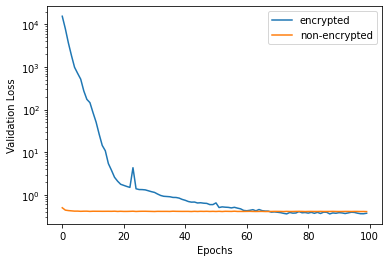

In [86]:
ax = plt.gca()
plt.plot(hist.history['val_loss'][:100], label='encrypted')
plt.plot(n_hist.history['val_loss'], label='non-encrypted')
ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.set_ylabel('Validation Loss')
ax.legend()
plt.savefig('loss.png')

In [63]:
hist.history

{'loss': [28382.495664399245,
  13402.723376786733,
  6341.184208310884,
  3221.715593318668,
  1714.2715883699923,
  998.2361781679351,
  617.0111411290043,
  392.0113632325952,
  261.9731094484155,
  175.48455197332356,
  112.27682571237034,
  69.53902961467874,
  40.90486662092847,
  23.511705179968907,
  13.394550456962044,
  7.538621632612743,
  4.576073684266808,
  3.1472293292049462,
  2.3727883877908966,
  1.9639943223937772,
  1.7632990414182264,
  1.649509895041313,
  1.5747308303086318,
  7.116095178630241,
  1.4621233458934884,
  1.3773454124255307,
  1.355779785897137,
  1.3317802570170854,
  1.2978579688507452,
  1.2521996321591111,
  1.191371603258725,
  1.1295948304825332,
  7.103011220330883,
  0.9602428425035419,
  0.9389504597467535,
  0.9258473511278992,
  0.911569877280183,
  0.8917568485586929,
  0.8650621751259113,
  0.8287165415214477,
  0.7852614307983894,
  6.661339722770223,
  0.7033261026862185,
  0.6863213605861394,
  0.6801413722018925,
  0.670618450605361